<center> 
    <h3><b> Adnan Rashid </b></h3>
    <nav>
    | <a href="00-Contents-Setup.ipynb"> Home Page </a> | 
    <a href="http://bit.ly/cka_notes_original"> Kubernetes Notes </a> |
    <a href="https://adnan.study"> Website </a> |
    <a href="https://www.instagram.com/adnans_techie_studies/"> Instagram </a> |
    <a href="https://www.linkedin.com/in/adnanrashid1/"> LinkedIn </a> |
    </nav>

</center>

<center><h1 style="background:black"><code style="background:black;color:white">Deploying MicroServices with AWS EFS</code></h1></center>

<div class="alert alert-block alert-warning">
<font style="color:black">
<center>In this section, we will create an EFS file system and share it across a set of stateful microservices deployed on AWS EKS which can all have concurrent access to the file system.
</center>
</font>
</div>

<center><img src="https://adnanstudyimages.s3-eu-west-1.amazonaws.com/27.jpg" width="40%" height="40%" border=5/></center>

<blockquote>Amazon Elastic File (EFS) provides a simple, scalable, fully managed elastic NFS file system for use with AWS Cloud services and on-premise resources.<br><Br>

It is built on demand to petabytes without disrupting applications, growing and shrinking automatically as you add and remove files, eliminating the need to provision and manage capacity to accomodate growth.

Amazon EFS supports the Network File System version 4 (NFSv4.1 and NFSv4.0) protocol, so the application and tools that you use today work seamlessly with Amazon EFS. 

Multiple EC2 instances can access an EFS file system at the same time, providing a common data source for workloads and applications running on more than one instance or server.  

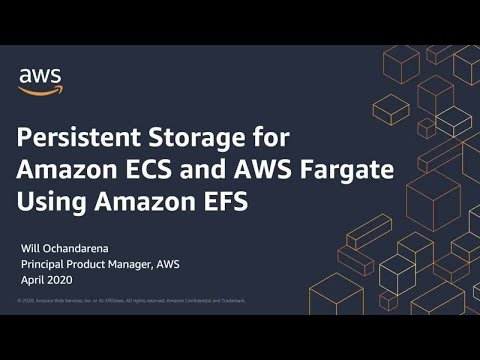

In [95]:
from IPython.display import YouTubeVideo
YouTubeVideo('XKFpKt7K0_4')

## Pre-requisite

* Check your variables are loaded

In [ ]:
%store

* Load in variable store

In [ ]:
%store -r 

* Load variables into notebook

In [ ]:
%env AWS_PROFILE=$AWS_PROFILE
%env AWS_DEFAULT_REGION=$AWS_DEFAULT_REGION
%env ACCOUNT_ID=$ACCOUNT_ID

* Check identity 

In [ ]:
!aws sts get-caller-identity

<br>

---
---

## <br><br> Creating an EFS File System

EFS file system may be created and configuring either from the AWS Management Console or using AWS CLI. 

An EFS file system may be accesssed concurrently by worker nodes (EC2 instances) running inside the EKS cluster VPC. 

Instances connect to a file system by using a network interface called a mount target. 

* First, let's define a set of environment variables pertaining to the name of your EKS cluster, VPC where it is deployed and the IPv4 CIDR block associated with that VPC. 

In [ ]:
%env CLUSTER_NAME=eksworkshop-eksctl

In [ ]:
!aws eks describe-cluster --name $CLUSTER_NAME --query "cluster.resourcesVpcConfig.vpcId" --output text

In [ ]:
%env VPC_ID=vpc-0a56b9642c5e016e0

In [ ]:
!aws ec2 describe-vpcs --vpc-ids $VPC_ID --query "Vpcs[].CidrBlock" --output text

In [ ]:
%env CIDR_BLOCK=192.168.0.0/16

Next, create a security group to be associated with the mount targets. 

* We will then, add an ingress rule to this security group that allows all inbound traffic using NFS protocol on port 2049 from IP addresses that belong to the CIDR block of the EKS cluster VPC. 

This rule will allow NFS access to the file system from all worker nodes in the EKS cluster 

In [ ]:
%env MOUNT_TARGET_GROUP_NAME=eks-efs-group
%env MOUNT_TARGET_GROUP_DESC=NFS access to EFS from EKS worker nodes

In [ ]:
!aws ec2 create-security-group --group-name $MOUNT_TARGET_GROUP_NAME --description "$MOUNT_TARGET_GROUP_DESC" --vpc-id $VPC_ID | jq --raw-output '.GroupId'

In [ ]:
%env MOUNT_TARGET_GROUP_ID=sg-09cdbd9cca480b788

In [ ]:
!aws ec2 authorize-security-group-ingress --group-id $MOUNT_TARGET_GROUP_ID --protocol tcp --port 2049 --cidr $CIDR_BLOCK

* Now we can create the EFS file system

In [ ]:
!aws efs create-file-system | jq --raw-output '.FileSystemId'

In [ ]:
%env FILE_SYSTEM_ID=fs-b7a5107d

* Check the <b> LifeCycleState </b> of the file system using the following command and wait until it changes from <b> creating </b> to <b> available </b> before you can proceed to the next step 

In [ ]:
!aws efs describe-file-systems --file-system-id $FILE_SYSTEM_ID

The EKS cluster that you created comprises worker nodes that are resident in the public subnet of the cluster VPC. 

Each public subnet resides in a different Availability Zone. 

As mentioned earlier, worker nodes connect to an EFS file system using a mount target. It is best to create a mount target in each of the EKS cluster VPC's availability zones so that worker nodes across your EKS cluster can all have access to the file system. 

* Setting some environment variables 

In [ ]:
%env TAG1=tag:kubernetes.io/cluster/eksworkshop-eksctl
%env TAG2=tag:kubernetes.io/role/elb

<br><br><b> Info </b>

When eksctl provisions your VPC and EKS cluster, it assigns the following tags to all public subnets in the cluster VPC. 

The command below leverages these tags to identify the public subnets. 

kubernetes.io/cluster/eksworkshop-eksctl = shared
kubernetes.io/role/elb = 1

If you have other VPC's sharing the same tags, the below may error. To prevent this, first get the subnets to check they are the right ones

* The following set of commands identifies the public subnets in your cluster VPC and creates a mount target in each one of them as well as associate that mount target with the security group you have created above. 

* Get subnets

In [ ]:
!aws ec2 describe-subnets --filters "Name=$TAG1,Values=shared" "Name=$TAG2,Values=1" | jq --raw-output '.Subnets[].SubnetId'

In [ ]:
%%bash

subnets=($(aws ec2 describe-subnets --filters "Name=$TAG1,Values=shared" "Name=$TAG2,Values=1" | jq --raw-output '.Subnets[].SubnetId'))
for subnet in ${subnets[@]}
do
    echo "creating mount target in " $subnet
    aws efs create-mount-target --file-system-id $FILE_SYSTEM_ID --subnet-id $subnet --security-groups $MOUNT_TARGET_GROUP_ID
done

<br><br>
Check the <b> LifeCycleState </b> of the mount targets using the following command and wait until it changes from <b> creating </b> to <b> available </b> before you proceed to the next step. 

It will take a frew minutes for all the mount targets to transition to <b> available </b> state. 

You may also check on the status of the mount targets from the EFS Dashboard on the AWS Management Console. 

* Select the file system you created and click on <b> Manage network access </b> to see the mount targets 

In [ ]:
!aws efs describe-mount-targets --file-system-id $FILE_SYSTEM_ID | jq --raw-output '.MountTargets[].LifeCycleState'

## <br><br> Setting up the EFS File System

When an EFS file system is first created, there is only one root directory at /. 

We will have to first create a sub-directory under this root within the EFS file system. The EFS provisioner will create child directories under this sub-directory to back each PersistentVolume it provisions. 

In order to do that, we will need an EC2 instance in the EKS cluster VPC. We will use Amazon Linux 2 AMI and allow inbound acecss to that instance on port 22 so that SSH is possible. 

In [ ]:
%env SECURITY_GROUP_NAME=ec2-instance-group
%env SECURITY_GROUP_DESC=Allow SSH access to EC2 instance from Everywhere

* Set your own IP address 

In [ ]:
%env SOURCE_IP_ADDR=

* Create the security group 

In [ ]:
!aws ec2 create-security-group --group-name $SECURITY_GROUP_NAME --description "$SECURITY_GROUP_DESC" --vpc-id $VPC_ID | jq --raw-output '.GroupId'

* Set the security group id as env var

In [ ]:
%env SECURITY_GROUP_ID=sg-0c1b9924040e26bf0

* Authorise engress from your source IP 

In [ ]:
!aws ec2 authorize-security-group-ingress --group-id $SECURITY_GROUP_ID --protocol tcp --port 22 --cidr $SOURCE_IP_ADDR/32

* Set Image ID 

In [ ]:
%env IMAGE_ID=ami-07d9160fa81ccffb5

* Launch Instance, pick a subnet from before (make sure it is public subnet) 

In [ ]:
!aws ec2 describe-subnets --filters "Name=tag:aws:cloudformation:logical-id,Values=SubnetPublic*" | jq --raw-output '.Subnets[].SubnetId'

In [ ]:
%env subnet=subnet-0e6c52cbfdfcd446c

* Note the 'key-name' is 'eksworkshop' this is what we created at the very start of the project. 

In [ ]:
%%bash 

aws ec2 run-instances \
--image-id $IMAGE_ID \
--count 1 \
--instance-type t2.micro \
--key-name "eksworkshop" \
--security-group-ids $SECURITY_GROUP_ID \
--subnet-id $subnet \
--associate-public-ip-address |  jq --raw-output '.Instances[0].InstanceId'

* Set Instance ID

In [ ]:
%env INSTANCE_ID=i-05bd714f466186938

<br><br>SSH into the EC2 instance by running the following command. 

* You may need to wait for the instance to be launched and transitions into a ready state 

In [ ]:
!aws ec2 describe-instances --instance-id $INSTANCE_ID | jq --raw-output '.Reservations[0].Instances[0].PublicIpAddress'

* Change the permissions otherwise you will not be able to login

In [ ]:
!chmod 400 temp/eksworkshop.pem

* Run the following in terminal

<p style="background:black">
<code style="background:black;color:white">> ssh ec2-user@34.243.44.220 -i temp/eksworkshop.pem</code></p>

<br><br><b> Note </b>
The DNS name of your EFS file system is contructed using the following convention
* file-system-id.efs.aws-region.amazonaws.com

For example 
*fs-dc133b8.efs.us-east-2.amazonaws.com 

* After you SSH into the EC2 instance, set an environment variable with its value set to the DNS name of your EFS file system contructed per the above convention. 

You may also get this information from the EFS Dashboard on the AWS Management Console 

In [ ]:
!aws efs create-file-system | jq --raw-output '.FileSystemId'

* Execute the following set of commands which will mount the root directory of the EFS file system, identified by the file system DNS name, on to the <b>efs-mount-point</b> local directory of the EC2 instance and then create a sub-directory named <b> data</b> under the root directory of the EFS file system. 

* Setup of the EFS file system is now complete and it is ready for use by containers deployed on EKS. 

## <br><br> EFS Provisioner for EKS: How it Works 

The <a href="https://github.com/kubernetes-retired/external-storage/tree/master/aws/efs"> EFS Provisioner <a> is deployed as a Pod that has a container with access to an AWS EFS file system. 

The container reads a <b> ConfigMap </b> containing the File system ID, Amazon Region of the EFS file system, and the name of the provisioner

   A <b> StorageClass </b> resource is defined whose <b> provisioner </b> attribute determines which volume plugin is used for provisioning a <b> PersistentVolume </b>. In this case, the StorageClass specifies the EFS Provisioner Pod as an external provisioner by referencing the value of <b> provisioner.name </b> key in the ConfigMap above. 

A <b> PersistentVolumeClaim (PVC) </b> resource is created that references the above StorageClass using the annotation <b> volume.beta.kubernetes.io/storage-class </b>. A PVC represents a request for storage by a user. 

A sub-directory named <b> data </b> was created under the root of the EFS file system for the EFS Provisioner Pod to use. This is configured in the EFS Provisioner deployment manifest under volumes/nfs/path. This directory is then mounted on to a local directory within the pod specified in the manifest under containers/volumeMounts/mountPath. The EFS Provisioner Pod will create child directories under this directory to back each PV it provisions

With this setup, EKS resources such as <b> Deployments, CronJobs, StatefulSets </b> etc. that need a persistent volume for data storage on the EFS file system may request one by referncing an instance of VPC in their respective YAML manifest such that its <b> claimName </b> attribute under <b> volumes/persistentVolumeClaim </b> matches the <b> name </b> attribute of the PVC definition. If a PV that matches the PVC request does not yet exist, it will be dynamically provisioned and then mounted on to a local directory within the pod specified in the manifest under <b> containers/volumeMounts/mountPath</b> 

    
    
<b> Note </b> 
    
If different sets of microservices in your deployment need to share different directories, then you need to create a new instance of a PersistentVolumeClaim for each shared directory. The corresponding PersistentVolume will be backed by a new child directory created under the top-level directory /data on the same EFS file system. There is no need to provision a new instance of an EFS file system unless your daa isolation requiremetns demands as such as. 

## <br><br> Deploying the EFS Provisioner

Lets deploy the EFS provisioner prod and a PVC to the cluster. 

Open the file <b> efs/efs-provisioner-deployment.yaml </b> in an editor, scoll down to the bottom of the file and replace the following 3 placeholders strings with the respective value from your EFS file system settings. 

Do not change any of the other environment variables in the file 

* YOUR_FILE_SYSTEM_DNS_NAME
* YOUR_FILE_SYSTEM_ID 
* YOUR_FILE_SYSTEM_REGION 

* Deploy the provisioner pod and PVC with the following

In [ ]:
!kubectl apply -f efs/efs-provisioner-deployment.yaml 
!kubectl apply -f efs/efs-pvc.yaml 

* Next, check if a PVC resource was created. The output from the command should look similar to what is shown below, with the status field set to bound

In [ ]:
!kubectl get pvc -n storage

* A PV corresponding to the above PVC is dynamically created. Check its status with the following command. 

In [ ]:
!kubectl get pv 

You may launch a command shell within the EFS Provisioner pod and inspect the local directory <b> /efs-mount </b>. 

This is the directory within the pod on to which <b> /data </b> directory of the EFS file system was mounted. 

* Run the following set of commands to first get the name of the EFS provisioner pod and then open up a command shell within the pod.

In [ ]:
!kubectl get pods -n storage

* Run the following in a terminal

<p style="background:black">
<code style="background:black;color:white">> kubectl exec -it efs-provisioner-59bb4b55fd-74ghm -n storage -- /bin/sh
</code>
</p>


* Within the pod run the following

A sub-directory would have been created under <b> /efs-mount </b> to back the PV resource listed above. The name of this directory is constructed based on the name and ID attributes of the corresponding VPC. 

Whenever a new instance of PVC is created, the EFS Provisioner will dynamically create a PV instance as well as create child directory under <b> /data </b> directory of the EFS file system to back that PV. 

There is always a one-to-one correspondance between a PV and a PVC. 

## <br><br> Deploying the Stateful Service 

* Launch a set of two pods

In [ ]:
!kubectl apply -f efs/efs-writer.yaml
!kubectl apply -f efs/efs-reader.yaml 

Each one of these pods references the PVC resource named <b> efs-storage-claim </b> created earlier and mounts the backing PV to a local directory named <b> /shared </b>

* Verify that the <b> efs-writer </b> pod is successfully writing data to the shared persistent volume in the terminal 

In [ ]:
!kubectl exec -it efs-writer -n storage -- tail /shared/out.txt

* Verify that the <b> efs-reader </b> pod is able to successfully read the same data from the shared persistent volume. 

In [ ]:
!kubectl exec -it efs-reader -n storage -- tail /shared/out.txt 

* Verify that this file resides on the EFS file system using EFS Provisioner pod. 

You can find this on the ec2 instance by looking at the data folder created earlier

In [ ]:
!kubectl exec -it efs-provisioner-59bb4b55fd-74ghm -n storage -- tail -f /efs-mount/efs-storage-claim-pvc-ed2f0cc4-f2ef-415e-b9d6-971ff7f51998/out.txt

* Delete both the efs-writer and efs-reader pods 

In [ ]:
!kubectl delete pod efs-writer -n storage 
!kubectl delete pod efs-reader -n storage 

* Verify that the file <b> out.txt </b> continues to live on the EFS file system.

In [ ]:
!kubectl exec -it efs-provisioner-59bb4b55fd-74ghm -n storage -- tail -f /efs-mount/efs-storage-claim-pvc-ed2f0cc4-f2ef-415e-b9d6-971ff7f51998/out.txt

## <br><br> Clean Up

* Delete the kubernetes resources deployed to the EKS cluster 

In [ ]:
!kubectl delete -f efs/efs-pvc.yaml 
!kubectl delete -f efs/efs-provisioner-deployment.yaml 
!aws ec2 terminate-instances --instance-ids $INSTANCE_ID

* Delete the mount targets associated with the EFS file system 

In [ ]:
%%bash

targets=$(aws efs describe-mount-targets --file-system-id $FILE_SYSTEM_ID | jq --raw-output '.MountTargets[].MountTargetId')
for target in ${targets[@]}
do
    echo "deleting mount target " $target
    aws efs delete-mount-target --mount-target-id $target
done

* Check the status of the EFS file system to find out if the mount targets have all been deleted

In [ ]:
!aws efs describe-file-systems --file-system-id $FILE_SYSTEM_ID

* When the <b> NumberOfMountTargets</b> is 0, run the following

In [ ]:
!aws efs delete-file-system --file-system-id $FILE_SYSTEM_ID

* Check and you should get an error

In [ ]:
!aws efs describe-file-systems --file-system-id $FILE_SYSTEM_ID